In [10]:
import freud
import gsd.hoomd
import matplotlib.pyplot as plt
import numpy as np
import sys
from itertools import *
import MDAnalysis.units  # for bulk water density
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import sys
import glob
import pandas as pd


In [38]:


def calculate_standard_error(data_column):
    """
    Calculate the standard error of the mean for a given data column.
    """
    if len(data_column) == 0:
        raise ValueError("Input array 'data_column' is empty.")

    error_den = np.std(data_column) / np.sqrt(len(data_column))
    return error_den
def adjust_rdf_for_density(radii, rdf_values, box_length):
    """
    Adjust the radial distribution function (RDF) for density effects.

    Parameters:
    radii (numpy.ndarray): Array of radial distances.
    rdf_values (numpy.ndarray): Original RDF values.
    box_length (float): Length of the cubic simulation box.

    Returns:
    numpy.ndarray: Adjusted RDF values.
    """
    dr = radii[1] - radii[0]  # Calculate the radial step size
    volume = box_length ** 3  # Calculate the volume of the simulation box
    N_outer = 1 - (4/3) * np.pi * radii**3 / volume  # Calculate the outer number density
    delta_n = (1 / volume) * 4 * np.pi * dr * np.cumsum((rdf_values - 1) * radii**2)  # Adjust for density

    # Return the adjusted RDF
    return rdf_values * N_outer / (N_outer - delta_n)

def compute_b22(radii, rdf_values, molecular_weight):
    """
    Calculate the second virial coefficient (B22) from the RDF.

    Parameters:
    radii (numpy.ndarray): Array of radial distances.
    rdf_values (numpy.ndarray): Adjusted RDF values.
    molecular_weight (float): Molecular weight of the substance.

    Returns:
    float: The second virial coefficient (B22) in µl mol / g².
    """
    b22 = -2 * np.pi * np.trapz((rdf_values - 1) * radii * radii, radii)  # Compute B22 using trapezoidal integration

    return b22 * 6.022e23 / 1e21 / molecular_weight**2 * 1e3 # convert to unit


In [12]:
path='./'

50
.//seq1/out_1_dump.dcd
1
21


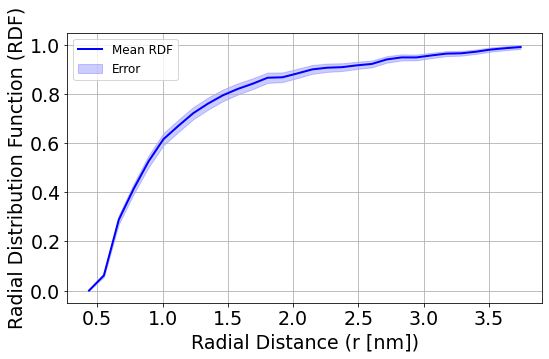

.//seq2/out_1_dump.dcd
2
21


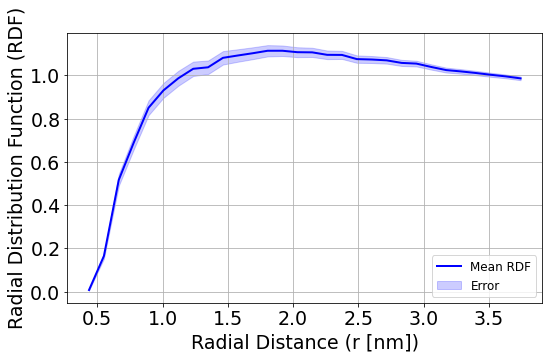

.//seq3/out_1_dump.dcd
3
21


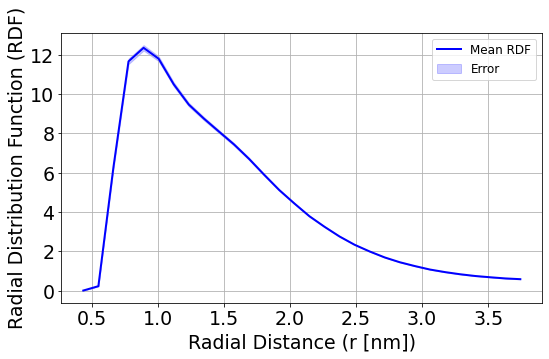

In [43]:
sequences = []

sequence_file='seq_b22_data_init0.csv' #sys.argv[1]

with open(sequence_file, "r") as file:
    next(file)  # Skip the header
    for line in file:
        sequence = line.split(",")[0]  # Extract the sequence from each line
        sequences.append(sequence.strip())  # Add the sequence to the list, removing leading/trailing whitespace

for i in range(1,4):
    seqNo=i
    reader = mda.coordinates.DCD.DCDReader(path+'/seq{}/out_1_dump.dcd'.format(seqNo))

    L=reader.dimensions[0]
    nbins = 30
    rmax = 3.8 #*L/8
    k=0
    rdf_bincount = np.zeros(nbins)
    bincount=np.zeros((0,nbins))
    rdf = freud.density.RDF(bins=nbins, r_max=rmax, r_min=0.38)
    rdf_array=np.zeros((reader.n_frames,30))
    len_seq=int(reader.n_atoms/2) #len(sequences)
                
    for frame in reader:

        

        points1 = frame.positions[:len_seq] #u.select_atoms('resid 0:21') #snap.particles.position[:polyCount1] 
        points2 = frame.positions[len_seq:] #snap.particles.position[14000:14000+polyCount2] #freud.locality.AABBQuery(box, pos2).points

        #nlist = aq.query( points1, {"r_max": r_max, "exclude_ii": True}).toNeighborList()

        #rdf.compute(system=(box, points1), query_points=points2,  reset=False)

        box = freud.box.Box.from_matrix(frame.triclinic_dimensions)

        rdf.compute(system=(box, points1), query_points=points2)
        #rdf.compute(system=(box, points1), query_points=points2,  reset=False)
        rdf_array[k] = rdf.rdf
        k+=1
        
    import matplotlib.pyplot as plt
    #####################################################################################################
    # Calculate the mean RDF and error
    mean_rdf = rdf_array.mean(axis=0)
    rdf_error_list = np.array([calculate_standard_error(rdf_array[:, j]) for j in range(30)])

    # Create the plot
    plt.rcParams.update({'font.size': 19})
    plt.figure(figsize=(8, 5))  # Set the figure size

    plt.fill_between(
        rdf.bin_centers, 
        mean_rdf - rdf_error_list, 
        mean_rdf + rdf_error_list, 
        color='blue', 
        alpha=0.2,  
        label='Error'
    )

    plt.plot(
        rdf.bin_centers, 
        mean_rdf, 
        color='blue', 
        label='Mean RDF', 
        linewidth=2
    )

    plt.xlabel('Radial Distance (r [nm])')
    plt.ylabel('Radial Distribution Function (RDF)') 
    
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.tight_layout() 
    plt.show()
    #####################################################################################################

    file_path = path+"rdf_seq{}.txt".format(seqNo)

    np.savetxt(file_path, rdf_array)
   

In [47]:

B22_array=np.zeros(len(sequences))

for i in range(1,4):

    # Load rdf data from a file
    rdf_seq1 = np.genfromtxt(path+'rdf_seq{}.txt'.format(i))

    # Calculate the standard error of the mean for each column in rdf_seq1
    # rdf_error_list = [calculate_standard_error(rdf_seq1[:, j]) for j in range(30)]
    # rdf_error_list = np.array(rdf_error_list)

    # Calculate mean values for each column in rdf_seq1
    mean_rdf = rdf_seq1.mean(axis=0)

    r=rdf.bin_centers
    u=mda.Universe(path+'seq{}/out_1restart1.gsd'.format(i),path+'seq{}/out_1_dump.dcd'.format(i))
    L=u.dimensions[0]

    natoms=int(u.atoms.n_atoms/2)
    MW = u.atoms[:natoms].masses #u.residues[:21].atoms.masses

    crdf = adjust_rdf_for_density(r,mean_rdf,L)
    B22= compute_b22(r,crdf,MW.sum())
    print('B22 for sequence {}={} µl mol / g²'.format(sequences[i-1],B22))
    B22_array[i-1]=B22



B22 for sequence MNNDKIIIENIKDYYDSYDNP=0.9418358719415851 µl mol / g²
B22 for sequence MSADTSDFDRKLGGHDAYRKR=-0.5504933647584952 µl mol / g²
B22 for sequence RFWYRWFWWHWYWWYEWWWYY=-13.76540435276799 µl mol / g²
